In [53]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/time-machine/timemachine.txt


1. Load text as strings into memory.

2. Split the strings into tokens (e.g., words or characters).

3. Build a vocabulary dictionary to associate each vocabulary element with a numerical index.

4. Convert the text into sequences of numerical indices

In [54]:
import collections 
import re
import random
import torch
from torch.utils.data import Dataset, DataLoader

In [55]:
with open('/kaggle/input/time-machine/timemachine.txt',"r") as f:
    txt = f.read()

In [56]:
class Vocab:
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        #count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x:x[1], reverse=True)
        
        #list of unique tokens
        self.itos = list(sorted(set(['<unk>'] + reserved_tokens + [token for token, freq in self.token_freqs if freq >= min_freq])))
        self.stoi = {token: idx for idx,token in enumerate(self.itos) }
        
    def __len__(self):
        #length of vocabulary
        return len(self.itos)
    
    def __getitem__(self, tokens):
        #make tokens into indices
        if not isinstance(tokens,(list,tuple)):
            return self.stoi[tokens]
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self,indices):
        #make indixes into tokens
        if hasattr(indices,'__len__') and len(indices)>1:
            return [self.itos[int(index)] for index in indices]
        return slef.itos[indices]
    
    @property
    def unk(self):
        return self.token_to_idx['<unk>']

In [57]:
class text_dataset(Dataset):
    def __init__(self):
        pass
    def _load(self,path= '/kaggle/input/time-machine/timemachine.txt'):
        with open(path,"r") as f:
            return f.read()
    def _preprocess(self, text):
        return re.sub('[^A-Za-z]+',' ',raw_text).lower()
    def _tokenize(self,text):
        return list(text)
    def build(self,raw_text,vocab=None):
        tokens = self._tokenize(self._preprocess(raw_text))
        if vocab is None: vocab = Vocab(tokens)
        corpus = [vocab[token] for token in tokens]
        return corpus, vocab

In [58]:
data = text_dataset()
raw_text = data._load()
raw_text[:60]

"Project Gutenberg's The Time Machine, by H. G. (Herbert Geor"

In [68]:
text = data._preprocess(raw_text)
text[:60]

'project gutenberg s the time machine by h g herbert george w'

choice of tokens is a design choice
- word level tokens -- vocab large in size
- character level tokens -- vocab small in size

In [60]:
tokens = data._tokenize(text)
','.join(tokens[:30])

'p,r,o,j,e,c,t, ,g,u,t,e,n,b,e,r,g, ,s, ,t,h,e, ,t,i,m,e, ,m'

vocab:token-->index
corpus:token replaced by those indicies in the original text

In [61]:
# counter = collections.Counter(tokens)
# token_freqs = sorted(counter.items(), key=lambda x:x[1], reverse=True)
# itos = list(sorted(set(['<unk>'] + [token for token, freq in token_freqs if freq >= 0])))
# stoi = {token: idx for idx,token in enumerate(itos) }

In [62]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))


indices: [17, 19, 16, 11, 6, 4, 21, 0, 8, 22]
words: ['p', 'r', 'o', 'j', 'e', 'c', 't', ' ', 'g', 'u']


In [63]:
corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

(191720, 28)

In [69]:
words = text.split()
vocab = Vocab(words)
print(vocab.token_freqs[:10])
print(len(vocab))

[('the', 2440), ('and', 1313), ('of', 1272), ('i', 1267), ('a', 874), ('to', 775), ('in', 598), ('was', 553), ('that', 458), ('it', 452)]
4937


unigram--single word

In [65]:
import matplotlib.pyplot as plt

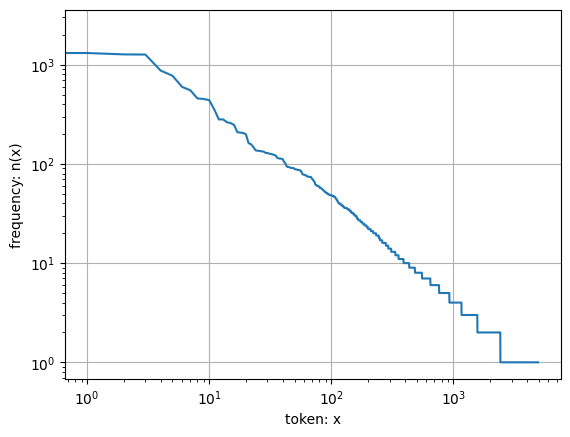

In [73]:
freqs = [freq for token,freq in vocab.token_freqs]
plt.plot(freqs)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('token: x')
plt.ylabel('frequency: n(x)')
plt.grid()
plt.show()

why a single frequency based model will fail?\\
because most of the high frequency words are stop words

In [79]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1],words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[('of--the', 335),
 ('in--the', 184),
 ('i--had', 130),
 ('and--the', 112),
 ('i--was', 112),
 ('the--time', 107),
 ('to--the', 101),
 ('it--was', 99),
 ('project--gutenberg', 87),
 ('as--i', 78)]

In [78]:
trigram_tokens = ['--'.join(triplet) for triplet in zip(words[:-2],words[1:-1],words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 59),
 ('project--gutenberg--tm', 57),
 ('the--time--machine', 35),
 ('the--project--gutenberg', 29),
 ('the--medical--man', 24),
 ('gutenberg--tm--electronic', 18),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14)]

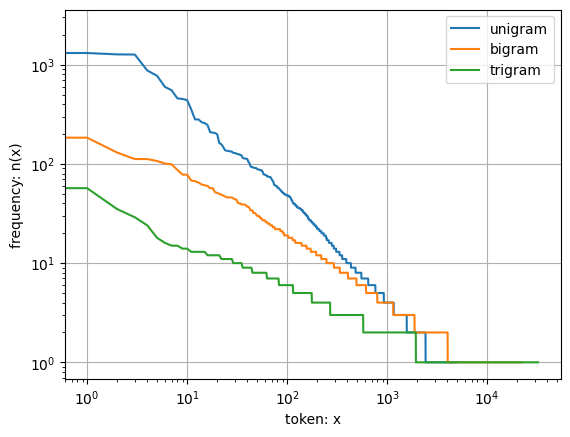

In [82]:
freqs = [freq for token,freq in vocab.token_freqs]
bigram_freqs = [freq for token,freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token,freq in trigram_vocab.token_freqs]

plt.plot(freqs,label='unigram')
plt.plot(bigram_freqs,label='bigram')
plt.plot(trigram_freqs,label='trigram')
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel('token: x')
plt.ylabel('frequency: n(x)')
plt.grid()
plt.show()

In [84]:
len(trigram_vocab)

32326

exercise:
1. min freq increse-->vocab_size decrease
2. fit a line to log of it